In [34]:
# import stuff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as mtick


# load data
data = pd.read_csv('abs_res_data_2.csv')

In [38]:
data.sample(7)
#data.info()

,measure,region,obs_value,unit_of_measure,unit_of_multiplier,date
627,Mean price of residential dwellings,Tasmania,3.560000e+05,Australian Dollars,Thousands,2017-01-01
1367,Number of residential dwellings,Australia,1.104120e+07,Number,Thousands,2023-04-01
1799,Value of dwelling stock: Owned by non households,Western Australia,2.947950e+10,Australian Dollars,Millions,2021-04-01
1812,Value of dwelling stock: Owned by non households,Western Australia,4.245490e+10,Australian Dollars,Millions,2024-07-01
1842,Value of dwelling stock: Owned by non households,Tasmania,5.990700e+09,Australian Dollars,Millions,2018-04-01
1315,Value of dwelling stock: Owned by non households,New South Wales,1.679875e+11,Australian Dollars,Millions,2024-01-01
2413,Value of dwelling stock: Owned by all sectors,New South Wales,4.050850e+12,Australian Dollars,Millions,2023-07-01


In [36]:
# lower case and place _between words
data.drop(columns=["MEASURE"], inplace=True)
data.drop(columns=["REGION"], inplace=True)
data.columns = (
    data.columns
    .str.strip()
    .str.lower()
    .str.replace(" ", "_")
    .str.replace(r"[^\w\s]", "", regex=True)
)

# remove columns with at least 1 null
data = data.dropna(axis=1, how="any")

# keep only relevant columns
keep_cols = ["measure", "region", "time_period", "obs_value", "unit_of_measure", "unit_of_multiplier"]
data = data[keep_cols]

In [37]:
scale_map = {
    "Units": 1,
    "Thousands": 1_000,
    "Millions": 1_000_000,
}

data["obs_value"] = data["obs_value"] * data["unit_of_multiplier"].map(scale_map)

data["year"] = data["time_period"].str[:4].astype(int)
data["quarter"] = data["time_period"].str[-2:]

# Map quarter to month (start of quarter)
q_map = {"Q1": 1, "Q2": 4, "Q3": 7, "Q4": 10}
data["month"] = data["quarter"].map(q_map)

# Create datetime column
data["date"] = pd.to_datetime(dict(year=data["year"], month=data["month"], day=1))

# Optional cleanup
data.drop(columns=["time_period", "year", "quarter", "month"], inplace=True)

## Let's Look At The Work We Did Yesterday First And Expand Upon It

It's a little messy, but you can follow the lines to see where each state and where the country overall lands. Many of them even have a similar starting position. 

I want to zoom in more on specifc states, but first I want to find a way to show this data with a bit more clarity. 

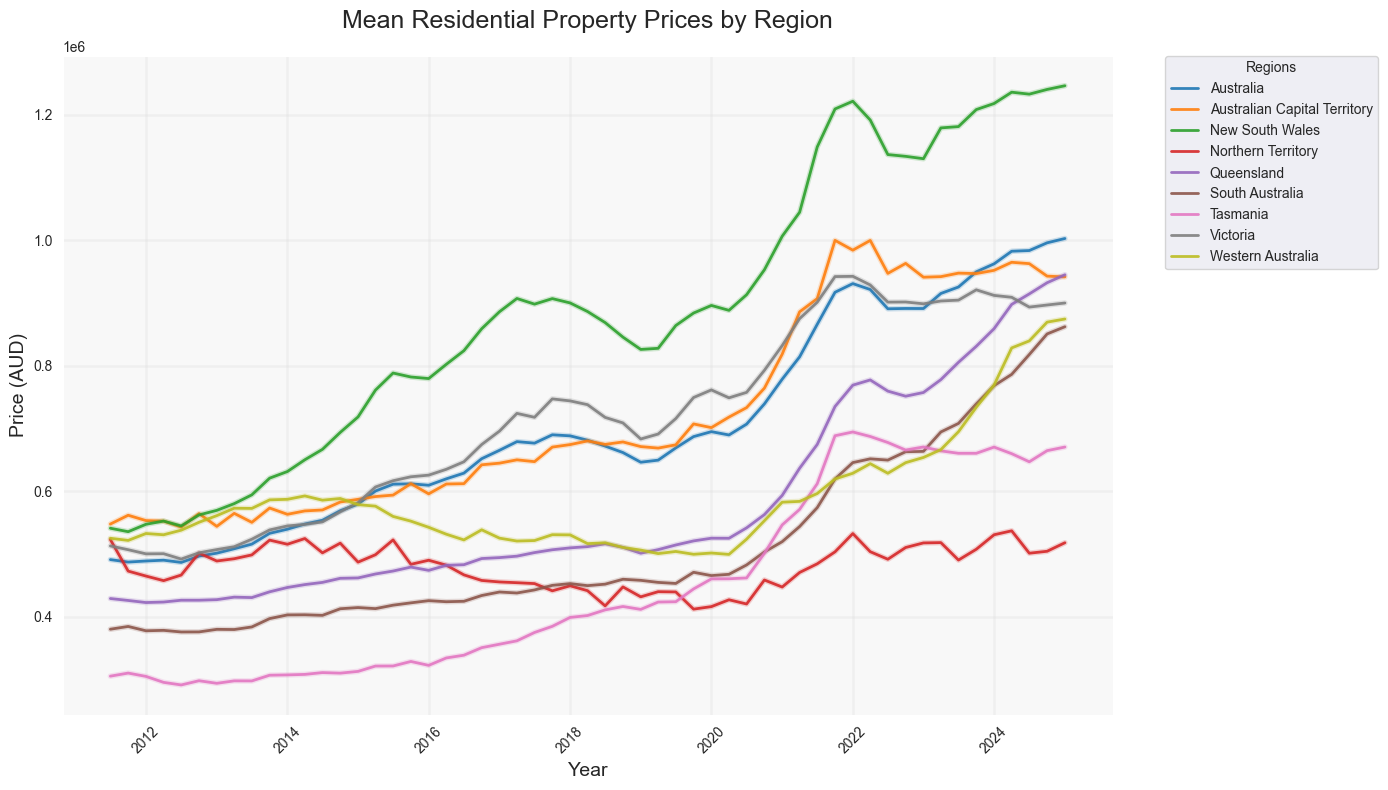

In [39]:
# pull out data where measure is "Mean price of residential dwellings"
mean_price = data[data["measure"] == "Mean price of residential dwellings"]
mean_pivot = mean_price.pivot(index="date", columns="region", values="obs_value")

# build the plot and grid
sns.set_style("darkgrid")
plt.figure(figsize=(14, 8))
colors = sns.color_palette("tab10", n_colors=len(mean_pivot.columns))
plt.grid(True, which='major', color="#DDDDDD", linewidth=1.8)
plt.grid(True, which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)

# plot a line for each region
for i, region in enumerate(mean_pivot.columns):
    plt.plot(mean_pivot.index, mean_pivot[region], 
             linewidth=4, alpha=0.2, color=colors[i])
    plt.plot(mean_pivot.index, mean_pivot[region], 
             label=region, 
             linewidth=2, 
             alpha=0.9,
             color=colors[i])

ax = plt.gca()
ax.set_facecolor('#f8f8f8')

# add titles and labels    
plt.title("Mean Residential Property Prices by Region",fontsize=18, pad=20)
plt.ylabel("Price (AUD)", fontsize=14)
plt.xlabel("Year", fontsize=14)
plt.grid(True, alpha=0.3)
plt.xticks(fontsize=10, rotation=45)
plt.yticks(fontsize=10)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, 
           frameon=True, fontsize=10, title="Regions")

plt.tight_layout()
plt.show()

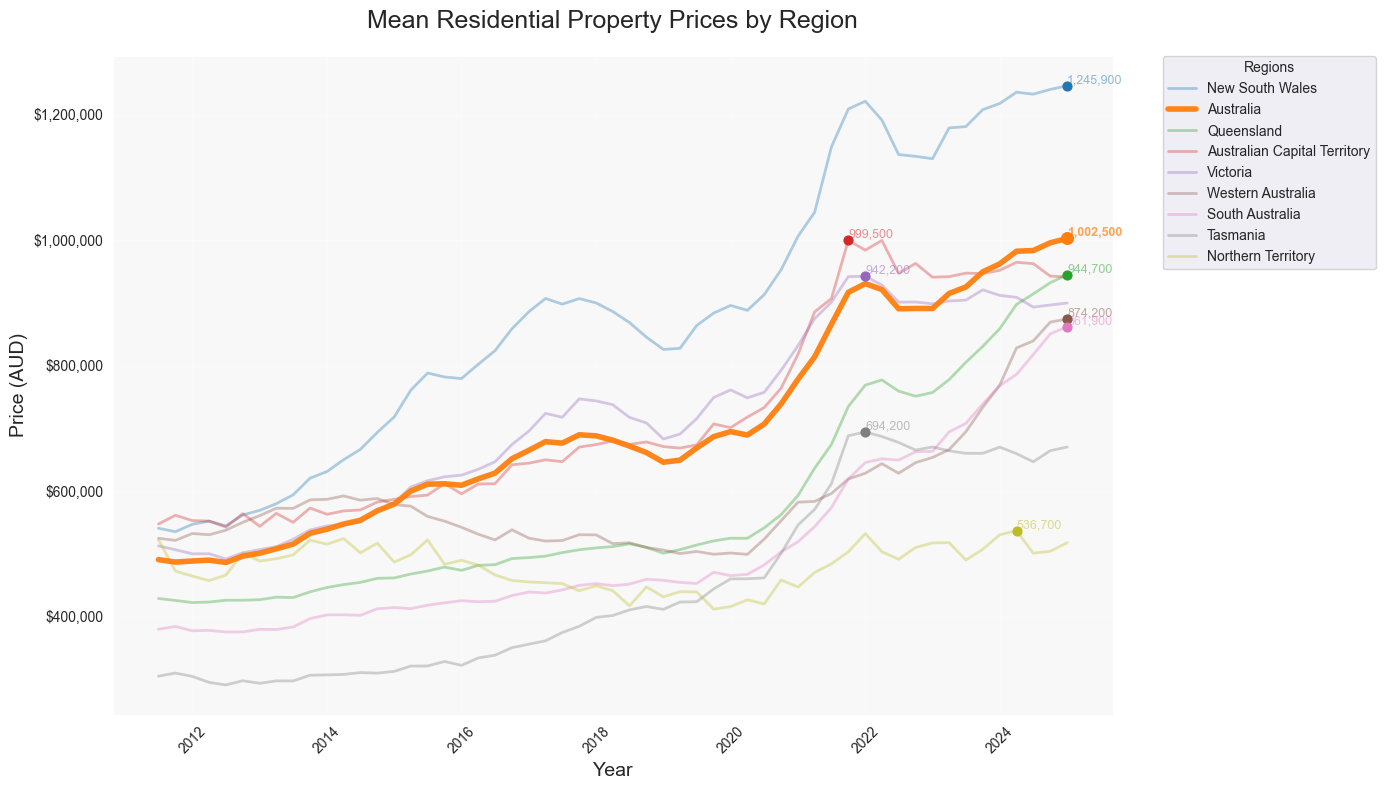

In [40]:
# ensure pivot table is sorted chronologically
mean_pivot = mean_pivot.sort_index()

# 2. Sort regions by latest value (descending)
final_vals = mean_pivot.iloc[-1].sort_values(ascending=False)
sorted_regions = final_vals.index.tolist()

# 3. Colors: Make Australia bold, others faded
colors = sns.color_palette("tab10", n_colors=len(sorted_regions))
region_color_map = {region: color for region, color in zip(sorted_regions, colors)}

plt.figure(figsize=(14, 8))
sns.set_style("darkgrid")

# 4. Plot
for region in sorted_regions:
    series = mean_pivot[region]
    color = region_color_map[region]
    # Highlight Australia
    if region.lower() == "australia":
        plt.plot(series.index, series.values,
                 label=region,
                 linewidth=4,
                 color=color,
                 alpha=0.95,
                 zorder=10)
    else:
        plt.plot(series.index, series.values,
                 label=region,
                 linewidth=2,
                 color=color,
                 alpha=0.35,
                 zorder=2)
    # Mark max point
    max_idx = series.idxmax()
    max_val = series.max()
    plt.scatter([max_idx], [max_val],
                color=color,
                s=70 if region.lower() == "australia" else 40,
                alpha=1,
                zorder=20)
    # Add text label for max (optional)
    plt.text(max_idx, max_val, f"{int(max_val):,}",
             fontsize=9,
             color=color,
             va="bottom",
             ha="left",
             fontweight="bold" if region.lower() == "australia" else "normal",
             alpha=0.7 if region.lower() == "australia" else 0.5)

# 5. Legend in value order
handles, labels = plt.gca().get_legend_handles_labels()
ordered = [labels.index(r) for r in sorted_regions if r in labels]
ordered_handles = [handles[i] for i in ordered]
ordered_labels = [labels[i] for i in ordered]

plt.legend(ordered_handles, ordered_labels, bbox_to_anchor=(1.05, 1), loc='upper left',
           borderaxespad=0, frameon=True, fontsize=10, title="Regions")

# 6. Layout, grid, etc
ax = plt.gca()
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'${x:,.0f}'))
plt.title("Mean Residential Property Prices by Region", fontsize=18, pad=20)
plt.ylabel("Price (AUD)", fontsize=14)
plt.xlabel("Year", fontsize=14)
plt.xticks(fontsize=10, rotation=45)
plt.yticks(fontsize=10)
plt.grid(True, alpha=0.3)
ax = plt.gca()
ax.set_facecolor('#f8f8f8')
plt.tight_layout()
plt.show()


## The Story Here Is Far More Clear

The Story here is of rising property prices with COVID being a particularly increadible growth period. But the whole period has show remarkable growth as a whole. 

This shows the different states better, in fact it shows that three states (and territories): ACT, Victoria & Tasmania had their peak in COVID and haven't gone above that high mark. 

There are also two insane stories here. 
1. NSW is definitely dragging that Australian average up in a major, major way. 
2. QLD has gone from bottom 3 to the 2nd most expensive state with ludicrous growth in the last two years. 

A final mention to how ACT, VIC, Tasmania have all maintained pretty stable values since high marks in COVID 2022 potentially indicating the effects of a policy reaction. 

### Let's now zoom in on NSW, what is going on there. 

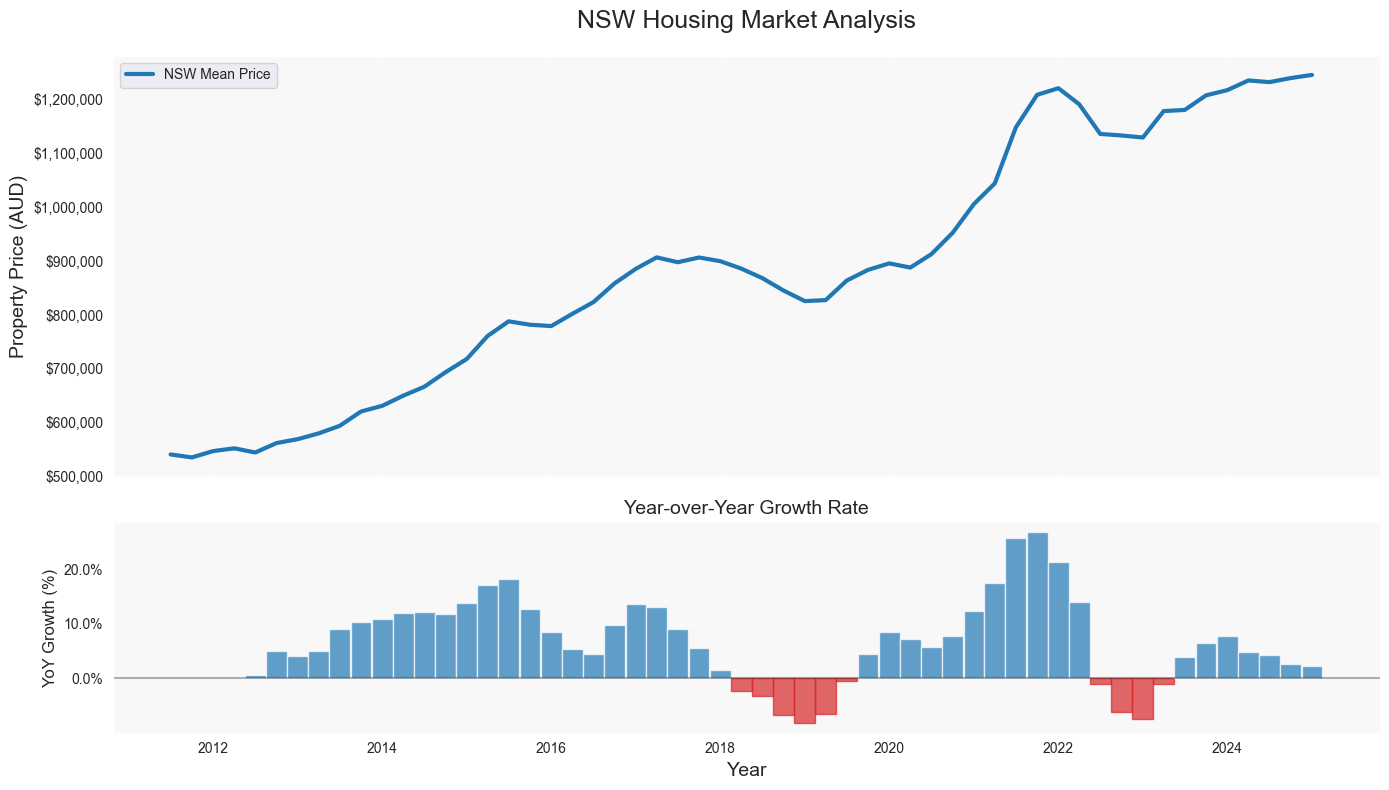

In [41]:
# focus on nsw
nsw_data = data[data["region"] == "New South Wales"]

# Create a figure with two subplots (panel analysis)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

# First subplot: NSW prices with key market events
mean_price_nsw = nsw_data[nsw_data["measure"] == "Mean price of residential dwellings"]
ax1.plot(mean_price_nsw["date"], mean_price_nsw["obs_value"], 
         linewidth=3, color="#1f77b4", label="NSW Mean Price")

# Add median price for comparison if available
median_price_nsw = nsw_data[nsw_data["measure"] == "Median price of residential dwellings"]
if not median_price_nsw.empty:
    ax1.plot(median_price_nsw["date"], median_price_nsw["obs_value"],
            linewidth=2, color="#ff7f0e", linestyle="--", label="NSW Median Price")

# Format y-axis with dollar formatting
from matplotlib.ticker import FuncFormatter
ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, p: f'${x:,.0f}'))

# Style the first subplot
ax1.set_title("NSW Housing Market Analysis", fontsize=18, pad=20)
ax1.set_ylabel("Property Price (AUD)", fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper left')
ax1.set_facecolor('#f8f8f8')

# Second subplot: Year-over-year growth rates
mean_price_nsw_sorted = mean_price_nsw.sort_values("date")
mean_price_nsw_sorted["rolling_yoy"] = mean_price_nsw_sorted["obs_value"].pct_change(periods=4) * 100  # 4 quarters = 1 year

# Plot the YoY growth
bars = ax2.bar(mean_price_nsw_sorted["date"], mean_price_nsw_sorted["rolling_yoy"], 
              width=90, alpha=0.7, color="#1f77b4")

# Color-code the bars based on positive/negative growth
for i, bar in enumerate(bars):
    if mean_price_nsw_sorted["rolling_yoy"].iloc[i] < 0:
        bar.set_color("#d62728")  # Red for negative growth

# Add a zero line
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)

# Format the y-axis as percentage
ax2.yaxis.set_major_formatter(FuncFormatter(lambda x, p: f'{x:.1f}%'))

# Style the second subplot
ax2.set_title("Year-over-Year Growth Rate", fontsize=14)
ax2.set_ylabel("YoY Growth (%)", fontsize=12)
ax2.set_xlabel("Year", fontsize=14)
ax2.grid(True, alpha=0.3)
ax2.set_facecolor('#f8f8f8')


props = dict(boxstyle='round', facecolor='white', alpha=0.7)

plt.tight_layout()
plt.show()

## NSW Housing Market Analysis — Quick Take

- Steady Long-term Growth: NSW’s mean residential property price shows a robust, steady increase from around $550k in 2011 to above $1.2M in 2024, nearly doubling over the period.
- Cyclical Corrections: The chart highlights clear cyclical downturns—noticeable negative YoY growth in 2018-2019 and again in 2022-2023—each followed by sharp recoveries.
- Peak Momentum: The sharpest annual price growth occurred in 2021-2022, exceeding 20% YoY, reflecting post-pandemic demand and low interest rates.
- Recent Slowdown: The latest bars show YoY growth moderating back toward zero in 2024, indicating a potential market plateau or the impact of interest rate hikes.
- Takeaway: NSW housing remains a long-term growth story, but volatility and corrections are a recurring feature—essential to factor in for timing and risk management.

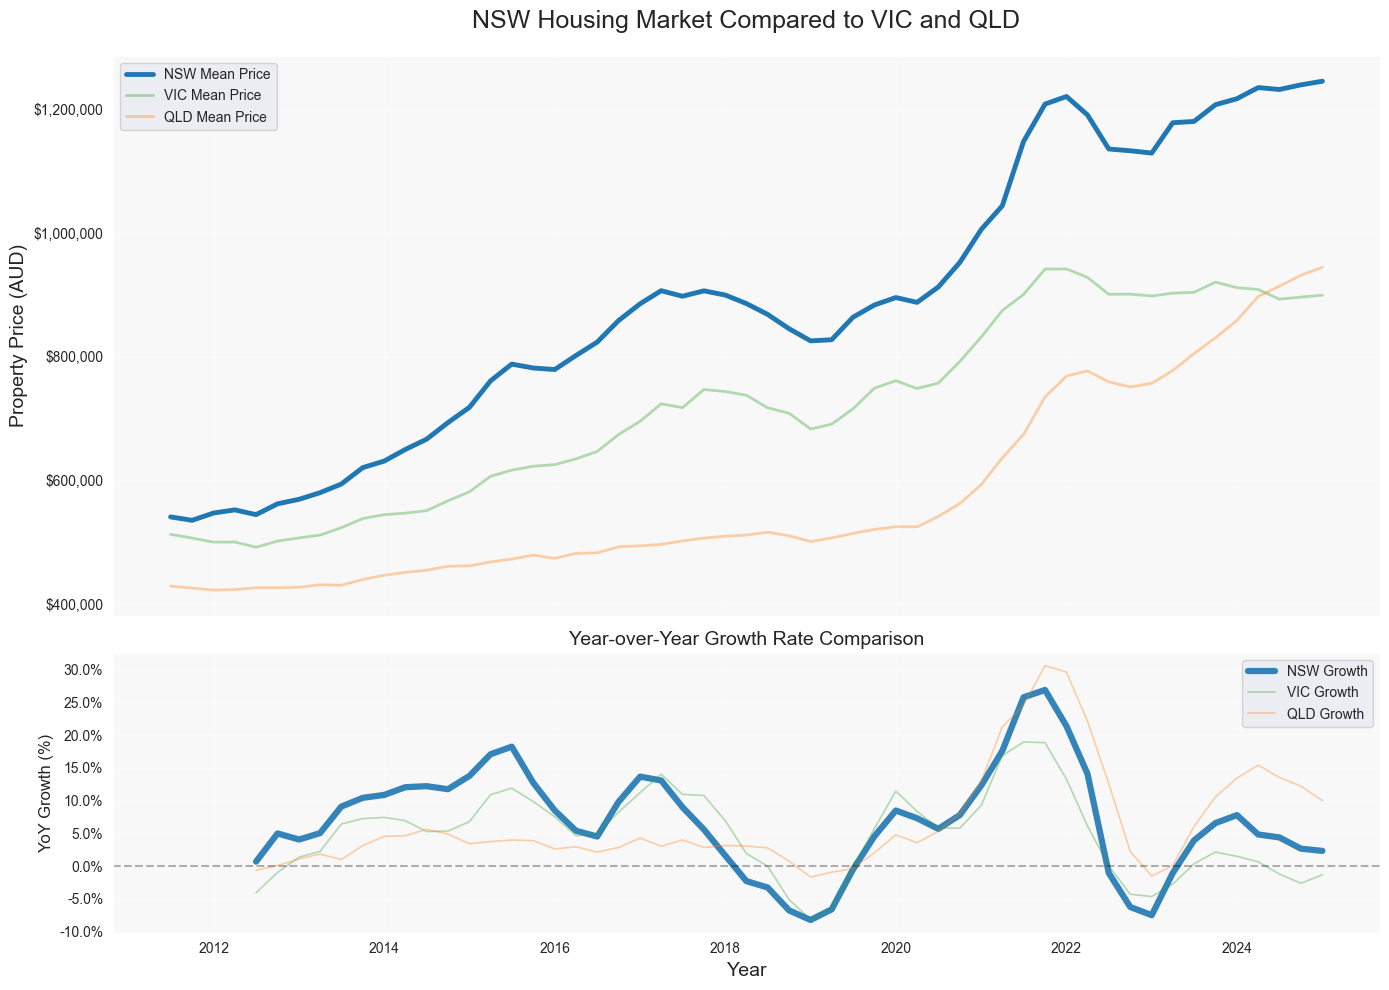

In [49]:
# Focus on NSW with VIC and QLD comparison
nsw_data = data[data["region"] == "New South Wales"]
vic_data = data[data["region"] == "Victoria"]
qld_data = data[data["region"] == "Queensland"]

# Create a figure with two subplots (panel analysis)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

# Get mean price data for each state
mean_price_nsw = nsw_data[nsw_data["measure"] == "Mean price of residential dwellings"]
mean_price_vic = vic_data[vic_data["measure"] == "Mean price of residential dwellings"]
mean_price_qld = qld_data[qld_data["measure"] == "Mean price of residential dwellings"]

# Plot NSW as the main line
ax1.plot(mean_price_nsw["date"], mean_price_nsw["obs_value"], 
         linewidth=3.5, color="#1f77b4", label="NSW Mean Price")

# Plot VIC and QLD with lower alpha
ax1.plot(mean_price_vic["date"], mean_price_vic["obs_value"],
        linewidth=2, color="#2ca02c", alpha=0.35, label="VIC Mean Price")
ax1.plot(mean_price_qld["date"], mean_price_qld["obs_value"],
        linewidth=2, color="#ff7f0e", alpha=0.35, label="QLD Mean Price")

# Format y-axis with dollar formatting
ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, p: f'${x:,.0f}'))

# Style the first subplot
ax1.set_title("NSW Housing Market Compared to VIC and QLD", fontsize=18, pad=20)
ax1.set_ylabel("Property Price (AUD)", fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper left')
ax1.set_facecolor('#f8f8f8')

# Calculate growth rates for each state
states_data = []
for state_data, color, name in zip(
    [mean_price_nsw, mean_price_vic, mean_price_qld],
    ["#1f77b4", "#2ca02c", "#ff7f0e"],
    ["NSW", "VIC", "QLD"]
):
    df = state_data.sort_values("date").copy()
    df["rolling_yoy"] = df["obs_value"].pct_change(periods=4) * 100
    states_data.append((df, color, name))

# Plot the YoY growth as lines
for df, color, name in states_data:
    alpha_val = 0.9 if name == "NSW" else 0.35
    linewidth = 4.5 if name == "NSW" else 1.2
    ax2.plot(df["date"], df["rolling_yoy"], 
            linewidth=linewidth, 
            color=color, 
            alpha=alpha_val,
            label=f"{name} Growth")

# Add a zero line
ax2.axhline(y=0, color='black', linestyle='--', alpha=0.3)

# Format the y-axis as percentage
ax2.yaxis.set_major_formatter(FuncFormatter(lambda x, p: f'{x:.1f}%'))

# Style the second subplot
ax2.set_title("Year-over-Year Growth Rate Comparison", fontsize=14)
ax2.set_ylabel("YoY Growth (%)", fontsize=12)
ax2.set_xlabel("Year", fontsize=14)
ax2.grid(True, alpha=0.3)
ax2.set_facecolor('#f8f8f8')
ax2.legend(loc='upper right')


plt.tight_layout()
plt.show()

## NSW, VIC, QLD Housing Market Comparison – Insights

- NSW Remains the Price Leader: NSW consistently commands the highest mean property price, now above $1.2M, while VIC tracks about $200k–$300k lower, and QLD remains the most affordable, just breaking the $800k mark recently.
- VIC & QLD Narrow the Gap: Both VIC and QLD have seen solid price growth, but QLD shows the most dramatic catch-up since 2021, nearly overtaking VIC in late 2024 for the first time in the series.
- Growth Cycles in Sync, but QLD More Volatile: All three states show pronounced cyclical booms and corrections, but QLD’s YoY growth rate is more volatile, spiking above 25% in 2022 and again in 2024, outpacing the southern states in those bursts.
- Recent Slowdown for NSW and VIC: After a strong surge in 2021–22, NSW and VIC growth rates have both flattened out, dipping back toward zero. QLD’s growth cooled less sharply, staying positive through the most recent data.
- Resilience and Opportunity: While NSW remains the benchmark, QLD’s rapid recent appreciation suggests increased demand and migration. VIC, meanwhile, continues to deliver steady, moderate gains, though it’s recently been outpaced by QLD.


# Final Thoughts

Looking at these charts, you get a sense of how unpredictable and uneven the property journey can be across Australia. We see prices climbing almost relentlessly in NSW, while QLD and VIC carve their own paths—sometimes following, sometimes diverging. There are moments of dizzying growth and patches where the market pulls back. It’s a reminder that, no matter how much we analyze, there’s no crystal ball.

But these lines don’t tell the whole story. **What’s not shown here are the personal stories:** first-home buyers scraping together deposits, families upsizing or downsizing, investors chasing growth, or people simply trying to keep up with rent. The data can’t capture changes in government policy, global shocks, or the real anxiety and hope people feel making these decisions. There are big factors—like interest rates, migration, and new housing supply—that live outside these numbers, but shape every trend we see.

**What I like about this visualization** is how it makes the patterns—and the differences between regions—so clear at a glance. You can see right away that NSW is the heavyweight, but QLD is on the move. The YoY growth subplot is especially useful: it doesn’t just show the levels, but the *momentum*—when things are heating up, and when they’re cooling off. The color and clarity help spot turning points quickly.

If you’re in the market, these trends are a reality check and a starting point—not the final word. The best thing we can do is stay curious, dig deeper, and remember that every market chart reflects thousands of individual stories, each trying to make it in this big, unpredictable world.
